# Udacity - Data Scientist Nanodegree
## Project 1: Write a data science blog post

### Exploring Airbnb data for London


<a name="intro"></a>
## 1. Introduction/Business Understanding
Despite the ongoing global turmoil caused by the spread of the novel coronavirus and the restrictions
of movement that people have to live with to contain the threat, it's safe to say that the people's desire
to travel to foreign countries and cities will be unbroken in the foreseeable future and travel platforms
like Airbnb will prosper again and keep being attractive for tourists and potential hosts.
But when you consider becoming a host on Airbnb you might want to gain a few insights before you publish your
first offer on the internet. The answers to the following questions might be of particular interest.

1. *What is the price distribution of listings in a specific city?*
2. *Given the room type, the amenities and the location you plan to offer: Which price should you determine for your listing?*
3. *How do you write an attractive description text for your listing?*

<a name="data"></a>
## 2. Data understanding / Data preparation
To address our questions we will use data from http://insideairbnb.com/index.html, a website sourcing
publicly available information from the Airbnb site. This data includes listings of accomodations of more than hundred cities worldwide, along with geo data of the cities' neighbourhoods. We will use the price, room type and amenities information of the listings to build a meaningful and characteristic feature set for a regression model.

Data used in the project:  
Airbnb data from http://insideairbnb.com/index.html:  
- `listings.csv` - detailed information on the listings of a specific city
- `neighbourhoods.csv`
- `neighbourhoods.geojson` GeoJSON file of neighbourhoods of the city, used for visualisations.

These data have all we need to be able to address our questions:

1. We will use information on prices, location and neighbourhoods from the listings file to analyze the price distribution.
2. We will use price, room type and amenities information of the listings file to build a meaningful and characeristic feature set for a regression model.
3. We will use the description text of the listings file to analyze a few properties of successful description texts.
 
We will arrange our code in a way to allow us to quickly analyze any of the cities in the insideairbnb data base. For our analysis we will use the City of London as an example.


*importing the libraries:*

In [2]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
import os, glob
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import re

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import missingno as msno

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# optimizing matplotlib params for medium output
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.labelsize']  = 'larger'
plt.rcParams['font.size']  = '14.0'
plt.rcParams['xtick.labelsize'] = '16'
plt.rcParams['ytick.labelsize'] = '16'

plt.style.use('fivethirtyeight')

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\norma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\norma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\norma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\norma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Airbnb data
First we'll define some helper functions for downloading data from insideairbnb.com with BeautifulSoup.
The files will be downoaded to a subfolder in the following folder path:  
+-- data  
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; +-- airbnb  
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+--airbnb_*city_name* (e.g. "airbnb_brussels")

`download_airbnb_data` takes a specific city name as a parameter and and uses the BeautifulSoup library to download the current csv and geojson files into a city specific folder
in the above mentioned directory.

In [3]:
data_folder = "./data/airbnb"

def download_airbnb_data(city):
    """
    downloads the listings.csv and geo data for a specific city from insideairbnb
    
    parameters:
        - city (str): name of the city to download
    
    """

    url_airbnb = "http://insideairbnb.com/get-the-data.html"
    search = city.lower()
    print(f"searching {search}")
    website_url = requests.get(url_airbnb).text
    soup = BeautifulSoup(website_url,'html.parser')
    table = soup.find('table',{'class':search})
    city_folder = f"{data_folder}/airbnb_{search}"
    if (table):
        print(search + " found. Looking for files ...")
        try:
            os.mkdir(city_folder)
        except FileExistsError:
            print('Directory already exists, not created.')
    trs = table.find_all('tr', class_=lambda x: x != 'archived')
    #trs = table.find_all('tr')
    file_found = False
    print("looking for listings...")
    for tr in trs:
        a = tr.find_all('a')
        for link in a:
            #print(re.search('csv$',link['href']))
            result = re.search('(.*listings\.csv(\.gz)?|neighbourhoods\.\w+|reviews\.csv\.gz)$',link['href'])
            if (result):
                filename = "-".join(link['href'].split("/")[-3:])
                filename = city_folder + '/' + filename
                download_file(link['href'], filename)
    print("Data download completed")
    
def download_file(url, filename):
    """
    INPUT:
        - url (str): URL of file
        - filename (str): save as filename
    """
    if os.path.exists(filename):
        print(f"{filename} already exists")
        return
    else:
        print("downloading: " + url)
        r = requests.get(url)
        with open(filename, 'wb') as f:
                    f.write(r.content)
        

#### Downloading city data
We will use the city of London as an example for the complete workflow. So let's download the data:

In [5]:
city = 'london'
download_airbnb_data(city)

searching london
london found. Looking for files ...
Directory already exists, not created.
looking for listings...
./data/airbnb/airbnb_london/2020-05-10-data-listings.csv.gz already exists
./data/airbnb/airbnb_london/2020-05-10-data-reviews.csv.gz already exists
./data/airbnb/airbnb_london/2020-05-10-visualisations-listings.csv already exists
./data/airbnb/airbnb_london/2020-05-10-visualisations-neighbourhoods.csv already exists
./data/airbnb/airbnb_london/2020-05-10-visualisations-neighbourhoods.geojson already exists
Data download completed


### Creating the data frames
Next we will create the data frames we will work with in the further stages of the project. To this end we will define several helper function with the
essential ones being:

`get_city_listings()`:

this function creates a first basic data frame loaded with airbnb listings by applying pandas `read_csv`.

In [4]:
def get_listings(city):
    """
    Returns a pandas data frame with the airbnb listings of a specific city
    
    INPUT:
        city (str) - the name of the city to load
    """
    city = city.lower()
    city_folder = f"{data_folder}/airbnb_{city}"
    path = glob.glob(f'{city_folder}/*listings.csv.gz')[0]
    print("loading " + path)

    df = pd.read_csv(path)
    
    print('done')
    return df
                         
def get_nbh_geojson(city):
    city = city.lower() 
    path = glob.glob(f"{data_folder}/airbnb_{city}/*neighbourhoods.geojson")[0]
    if (os.path.exists(path)):
        return path
    else:
        return "NA"
def get_reviews(city):
    city = city.lower() 
    path = glob.glob(f"{data_folder}/airbnb_{city}/*reviews.csv.gz")[0]
    print(path)
    if (os.path.exists(path)):
        df = pd.read_csv(path)
        df.date = pd.to_datetime(df.date)
        df = df.set_index('date')
        print('done')
        return df
    else:
        return None


**We will use London as our object of analysis**

In [25]:
city = 'London'
df_city = get_listings(city)

loading ./data/airbnb/airbnb_london\2020-05-10-data-listings.csv.gz


C:\Users\norma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


done


In [26]:
df_city.shape

(85207, 106)

So, there are 85,207 rows in our data set with 106 columns each.  
Let's take a look at these columns:

In [27]:
df_city.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

one of the most important columns for our analyis will be the price information, so let's see how it looks like:

In [28]:
df_city.price

0         $65.00
1        $100.00
2        $300.00
3        $150.00
4         $65.00
          ...   
85202    $100.00
85203    $100.00
85204    $100.00
85205    $100.00
85206     $35.00
Name: price, Length: 85207, dtype: object

Obviously, price is encoded as a string, so we need to convert it to float values:

In [29]:
# converting price column to float
df_city.loc[:,'price'] = df_city.price.str.replace('[\$,]','').astype(float)
df_city['price']

0         65.0
1        100.0
2        300.0
3        150.0
4         65.0
         ...  
85202    100.0
85203    100.0
85204    100.0
85205    100.0
85206     35.0
Name: price, Length: 85207, dtype: float64

From a quick look into the data file in excel we identify the following columns are of interest for our analysis:

In [30]:
columns = [
    'id',
    'name',
    'neighbourhood',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'bathrooms',
    'bedrooms',
    'bed_type',
    'amenities',
    'price',
    'accommodates',
    'description',
    'number_of_reviews',
    'review_scores_rating'
]

In [31]:
df_city = df_city[columns]

checking for price outliers:

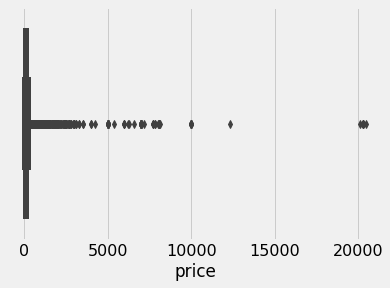

In [32]:
sns.boxplot(data=df_city, x='price')

as expected there are some massive outliers in the data set. We make the decision to focus on the 95% quantile of the data, which is:

In [33]:
df_city.price.quantile(0.95)

350.0

In [34]:
df_city= df_city[df_city.price <= df_city.price.quantile(0.95)] 
# dropping listings with 0 $ as well:
df_city = df_city[df_city.price > 0]

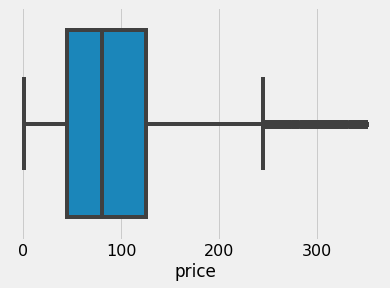

In [35]:
sns.boxplot(data=df_city, x='price')

this looks much better.

In [36]:
df_city.price.describe()

count    81195.000000
mean        96.317815
std         66.871274
min          1.000000
25%         45.000000
50%         80.000000
75%        125.000000
max        350.000000
Name: price, dtype: float64

Let's now take a look on missing values:

In [37]:
df_city.isna().sum()

id                            0
name                         23
neighbourhood                 0
neighbourhood_cleansed        0
latitude                      0
longitude                     0
property_type                 0
room_type                     0
bathrooms                   124
bedrooms                    144
bed_type                      0
amenities                     0
price                         0
accommodates                  0
description                2868
number_of_reviews             0
review_scores_rating      21038
dtype: int64

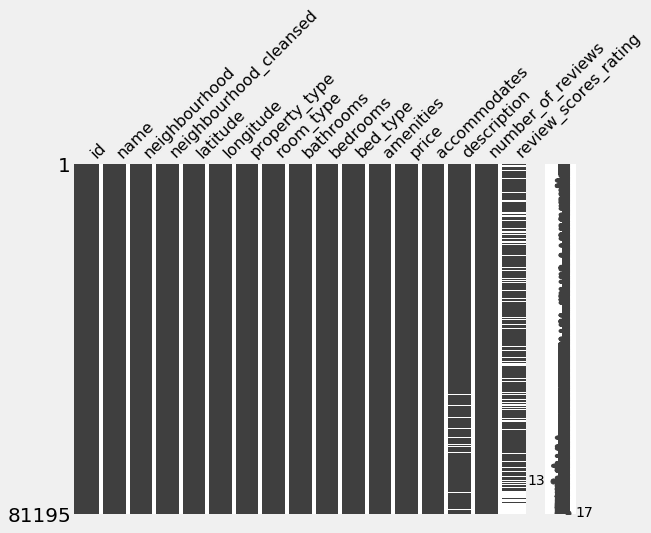

In [38]:
msno.matrix(df_city, figsize=(8,6))

So, the only columns where we have to take into account missing values are bathrooms and bedrooms (which we will address in question 2) and
a few missing descriptions and ratings. No need to do any imputings or deletions now.

## Model

### 1. *What is the price distribution of listings in London?*

Let's first plot the distribution of prices:

Text(0.5, 0, 'Price ($)')

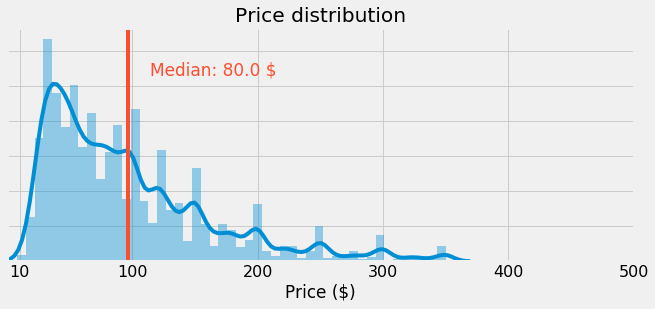

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
ax = sns.distplot(df_city.price)
plt.axvline(df_city.price.mean(), color="C1")
annot_text = f"Median: {round(df_city.price.median(),2)} $"
ax.annotate(annot_text, xy = (114, 0.0106), color='C1', fontsize=17)
ax.set(xscale='linear')
ax.set_xticks([1, 10, 100, 200, 300, 400, 500])
ax.set_xticklabels(["", 10, 100,200, 300, 400, 500])
ax.set_yticklabels([])
ax.set_xlim((0, 500))
ax.set_title('Price distribution')
ax.set_xlabel('Price ($)')

We then create a scatter plot with indicating the price level of each listing by its hue.

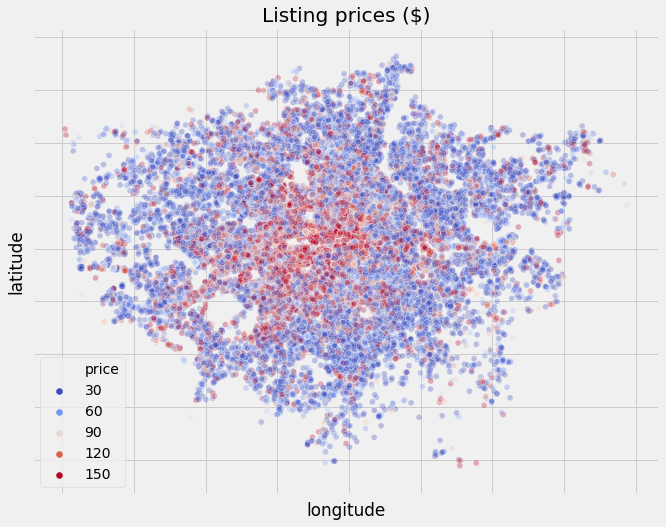

In [40]:
from matplotlib.colors import Normalize

df_city['price_log'] = np.log(df_city['price'])
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(data=df_city, x='longitude', y='latitude', hue='price', palette="coolwarm", alpha=0.3, hue_norm=Normalize(45,130))
ax.set_title('Listing prices ($)')
ax.set_xticklabels("")
ax.set_yticklabels("")
fig.savefig('./img/listing_prices_fig1.png', dpi=150)

So, there's an obvious accumulation of higher prices near the city center.  
Let's now aggregate the price levels for each neighbourhood and plot the averages:

[]

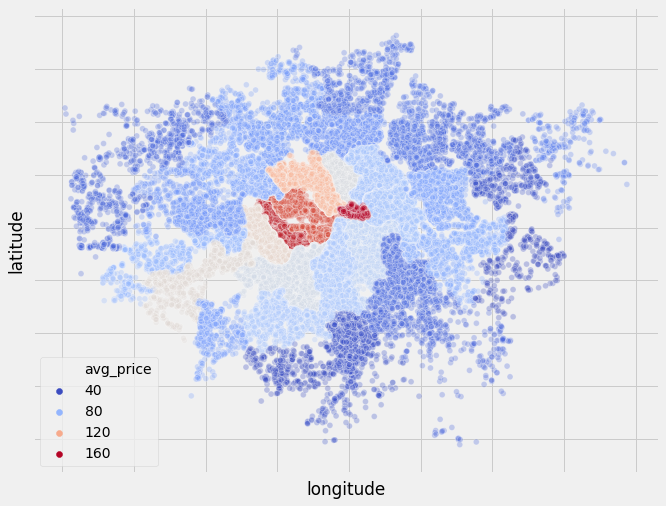

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
df_plot_data = pd.merge(df_city, df_city.groupby('neighbourhood_cleansed').agg(avg_price=('price', 'mean')), left_on='neighbourhood_cleansed', right_index=True)
df_plot_data['avg_price_log'] = np.log(df_plot_data.avg_price)
plt.style.use('fivethirtyeight')
ax = sns.scatterplot(data=df_plot_data, x='longitude', y='latitude', hue='avg_price', palette="coolwarm", alpha=0.3)
ax.set_xticklabels([])
ax.set_yticklabels([])


To create a price ranking by neighbourhood we wil group the data and create a barplot:

In [42]:
df_nbh = df_city.groupby('neighbourhood_cleansed').agg(avg_price=('price', 'median')).reset_index()

Text(0.5, 0, '')

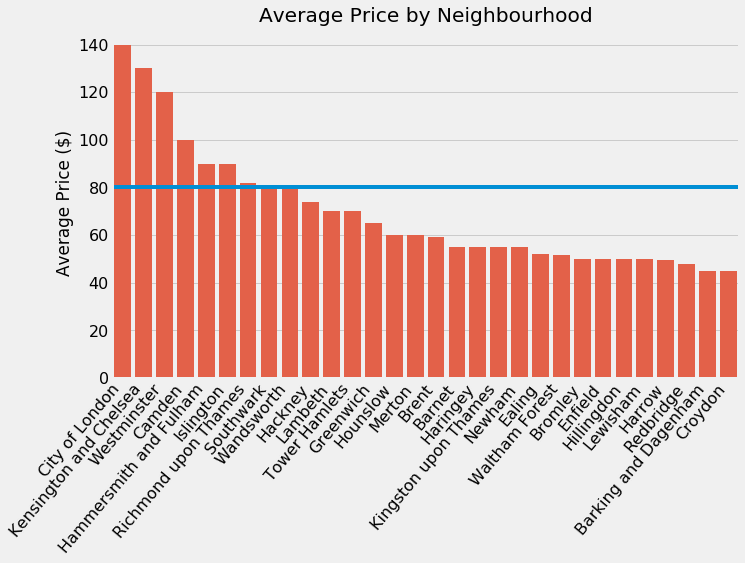

In [43]:
df_plot_data = df_nbh.nlargest(30, 'avg_price')
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(data=df_plot_data, x='neighbourhood_cleansed', y='avg_price', color='C1')
plt.axhline(df_city.price.median())
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
ax.set_title('Average Price by Neighbourhood')
ax.set_ylabel('Average Price ($)')
ax.set_xlabel('')

Next, we use the Folium library to plot the price levels for each neighbourhood

In [44]:
m = folium.Map(location=[51.5, 0.01], zoom_start=10, tiles='cartodbpositron', width='80%', height='80%')
folium.Choropleth(
    geo_data=get_nbh_geojson('London'),
    name='choropleth',
    data=df_nbh,
    columns=['neighbourhood_cleansed', 'avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Listing price ($)'
).add_to(m)

m

### 2. *How to determine a price as a host?*

Our goal is to develop a prediction model allowing a host to determine a price for a new listing by identifying the following criteria:
- the neighbourhood for the accomodation
- the room type
- property type
- amenities
- the number of accomodates

Most of these features are categorical variables, so we have to turn them into numerical values by creating dummy variables

**amenities**  
Let's start with the amenities. Let's first take a look how they are used:


In [45]:
df_city.amenities

0        {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...
1        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2        {TV,Wifi,Kitchen,"Paid parking off premises",E...
3        {TV,Internet,Wifi,"Air conditioning",Breakfast...
4        {TV,Wifi,Kitchen,"Free parking on premises",El...
                               ...                        
85202    {TV,Wifi,"Air conditioning",Kitchen,Heating,Wa...
85203    {TV,Wifi,Kitchen,Washer,Essentials,"Lock on be...
85204    {TV,Wifi,Kitchen,Washer,Essentials,"Lock on be...
85205    {TV,Wifi,Kitchen,Washer,Essentials,"Lock on be...
85206    {TV,Wifi,Kitchen,"Free parking on premises",He...
Name: amenities, Length: 81195, dtype: object

*amenities* are in the form "{ toilet, Wifi }". So, we have to parse this content before we can make use of it:

In [50]:
amenities_tmp = df_city.amenities.str.replace(r'[{}]', '').str.split(',').explode().str.replace('"', '').str.strip()
amenities_tmp.value_counts()

Wifi               77871
Heating            76811
Essentials         75815
Kitchen            74180
Smoke detector     70526
                   ...  
Private hot tub        1
Freezer                1
Garden                 1
Shared hot tub         1
Pool cover             1
Name: amenities, Length: 201, dtype: int64

We will condense all amenities with less than 50 appearances in an "other" category:

In [51]:
replace_dict = {x:'Other' for x in amenities_tmp.value_counts()[amenities_tmp.value_counts() < 50].index}
replace_dict

{'Pillow-top mattress': 'Other',
 'Amazon Echo': 'Other',
 'Mini fridge': 'Other',
 'Printer': 'Other',
 'Day bed': 'Other',
 'Private bathroom': 'Other',
 'Wine cooler': 'Other',
 'Firm mattress': 'Other',
 'Washer/Dryer': 'Other',
 'Sun loungers': 'Other',
 'Ceiling fan': 'Other',
 'Beachfront': 'Other',
 'Murphy bed': 'Other',
 'Outdoor parking': 'Other',
 'Shower chair': 'Other',
 'Bathtub with bath chair': 'Other',
 'Ski-in/Ski-out': 'Other',
 'Ground floor access': 'Other',
 'Fixed grab bars for shower': 'Other',
 'Exercise equipment': 'Other',
 'High-resolution computer monitor': 'Other',
 'Fax machine': 'Other',
 'Steam oven': 'Other',
 'Fire pit': 'Other',
 'Standing valet': 'Other',
 'Fixed grab bars for toilet': 'Other',
 'HBO GO': 'Other',
 'Warming drawer': 'Other',
 'Projector and screen': 'Other',
 'Bidet': 'Other',
 'Stand alone steam shower': 'Other',
 'Air purifier': 'Other',
 'Hammock': 'Other',
 'Dining table': 'Other',
 'Alfresco bathtub': 'Other',
 'Heat lamps': '

In [52]:
amenities_tmp = amenities_tmp.replace(replace_dict)

In [53]:
amenities_tmp.value_counts()

Wifi                        77871
Heating                     76811
Essentials                  75815
Kitchen                     74180
Smoke detector              70526
                            ...  
Wide clearance to shower       62
toilet                         62
Soaking tub                    61
Kitchenette                    55
Gas oven                       51
Name: amenities, Length: 145, dtype: int64

let's now build the dummies data frame:

In [54]:
amenities_dummies = pd.get_dummies(amenities_tmp, prefix='am').groupby(level=0).sum().iloc[:,1:-2]

In [55]:
amenities_dummies

,am_24-hour check-in,am_Accessible-height bed,am_Accessible-height toilet,am_Air conditioning,am_BBQ grill,am_Baby bath,am_Baby monitor,am_Babysitter recommendations,am_Baking sheet,am_Balcony,...,am_Wheelchair accessible,am_Wide clearance to shower,am_Wide doorway to guest bathroom,am_Wide entrance,am_Wide entrance for guests,am_Wide entryway,am_Wide hallways,am_Wifi,am_Window guards,am_toilet
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85202,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
85203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
85204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
85205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**room types**

In [85]:
df_city.room_type.value_counts()

Entire home/apt    44385
Private room       35549
Hotel room           643
Shared room          618
Name: room_type, dtype: int64

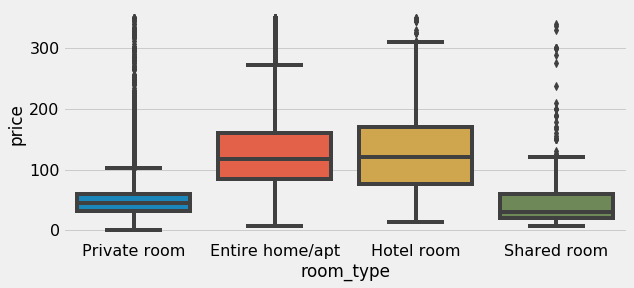

In [60]:
# to get a feeling for the room type's impact on price levels, we make a boxplot:
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(data=df_city, x='room_type', y='price')

In [61]:
#build the dummies
room_type_dummies = pd.get_dummies(df_city.room_type, drop_first=True)
room_type_dummies

,Hotel room,Private room,Shared room
0,0,1,0
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0
...,...,...,...
85202,0,1,0
85203,0,1,0
85204,0,1,0
85205,0,1,0


**neighbourhoods**

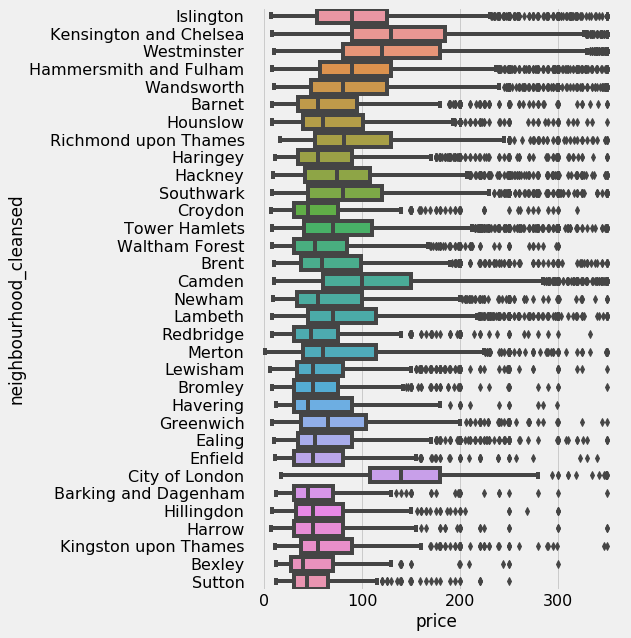

In [65]:
# to get a feeling for the room type's impact on price levels, we make a boxplot:
fig, ax = plt.subplots(figsize=(6,10))
sns.boxplot(data=df_city, y='neighbourhood_cleansed', x='price')

In [66]:
nbh_dummies = pd.get_dummies(df_city.neighbourhood_cleansed, drop_first=True,prefix='nbh')
nbh_dummies

,nbh_Barnet,nbh_Bexley,nbh_Brent,nbh_Bromley,nbh_Camden,nbh_City of London,nbh_Croydon,nbh_Ealing,nbh_Enfield,nbh_Greenwich,...,nbh_Merton,nbh_Newham,nbh_Redbridge,nbh_Richmond upon Thames,nbh_Southwark,nbh_Sutton,nbh_Tower Hamlets,nbh_Waltham Forest,nbh_Wandsworth,nbh_Westminster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
85203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
85204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
85205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**property type**

In [67]:
df_city.property_type.value_counts()

Apartment                        54680
House                            17001
Townhouse                         2691
Condominium                       2187
Serviced apartment                1264
Loft                               724
Bed and breakfast                  574
Guest suite                        379
Guesthouse                         310
Boutique hotel                     202
Other                              195
Hotel                              186
Bungalow                           163
Hostel                             151
Cottage                             89
Tiny house                          71
Aparthotel                          67
Boat                                58
Houseboat                           37
Villa                               31
Cabin                               26
Earth house                         21
Camper/RV                           17
Chalet                              14
Hut                                 11
Barn                     

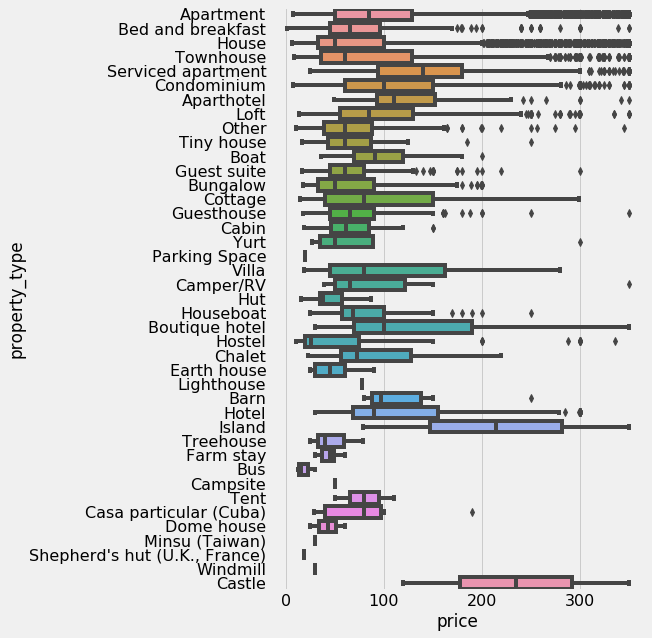

In [68]:
# to get a feeling for the room type's impact on price levels, we make a boxplot:
fig, ax = plt.subplots(figsize=(6,10))
sns.boxplot(data=df_city, y='property_type', x='price')

In [69]:
#creating the dummy variables:
property_type_dummies = pd.get_dummies(df_city.property_type, drop_first = True)
property_type_dummies

,Apartment,Barn,Bed and breakfast,Boat,Boutique hotel,Bungalow,Bus,Cabin,Camper/RV,Campsite,...,Parking Space,Serviced apartment,"Shepherd's hut (U.K., France)",Tent,Tiny house,Townhouse,Treehouse,Villa,Windmill,Yurt
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85202,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85203,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85204,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85205,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's now build the feature data frame by concatenating all the dummies and the price and accomodates columns from the original data frame:

In [70]:
# bulid feature frame:
df_features = pd.concat([df_city[['price', 'accommodates']], amenities_dummies, property_type_dummies, nbh_dummies,room_type_dummies], axis=1)
df_features

,price,accommodates,am_24-hour check-in,am_Accessible-height bed,am_Accessible-height toilet,am_Air conditioning,am_BBQ grill,am_Baby bath,am_Baby monitor,am_Babysitter recommendations,...,nbh_Richmond upon Thames,nbh_Southwark,nbh_Sutton,nbh_Tower Hamlets,nbh_Waltham Forest,nbh_Wandsworth,nbh_Westminster,Hotel room,Private room,Shared room
0,65.0,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,100.0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,300.0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,150.0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,65.0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85202,100.0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
85203,100.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
85204,100.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
85205,100.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


**let's now build the model with scikit learn**

In [87]:
# importing the regression libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [88]:
# building training and test set
X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[:,1:], df_features.iloc[:, 0],test_size= 0.2, random_state=42)
X_train

,accommodates,am_24-hour check-in,am_Accessible-height bed,am_Accessible-height toilet,am_Air conditioning,am_BBQ grill,am_Baby bath,am_Baby monitor,am_Babysitter recommendations,am_Baking sheet,...,nbh_Richmond upon Thames,nbh_Southwark,nbh_Sutton,nbh_Tower Hamlets,nbh_Waltham Forest,nbh_Wandsworth,nbh_Westminster,Hotel room,Private room,Shared room
52172,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
77229,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72924,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6361,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2844,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
56820,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
80417,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
881,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [97]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)
#model= LinearRegression()
model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100])
#model = Ridge(alpha=0.01)
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), cv=None,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [98]:
y_pred = model.predict(X_test)

In [99]:
# calculating r2-score
model.score(X_train, y_train)

0.5757161082582247

In [100]:
mean_squared_error(y_test, y_pred), mean_squared_error(y_train, model.predict(X_train))

(1905.296502077462, 1891.9922038031962)

So, we have moderate r2-value of 0.58 and comparable MSEs for the training and the test set.  
Let's now plot the predicted against the true prices:

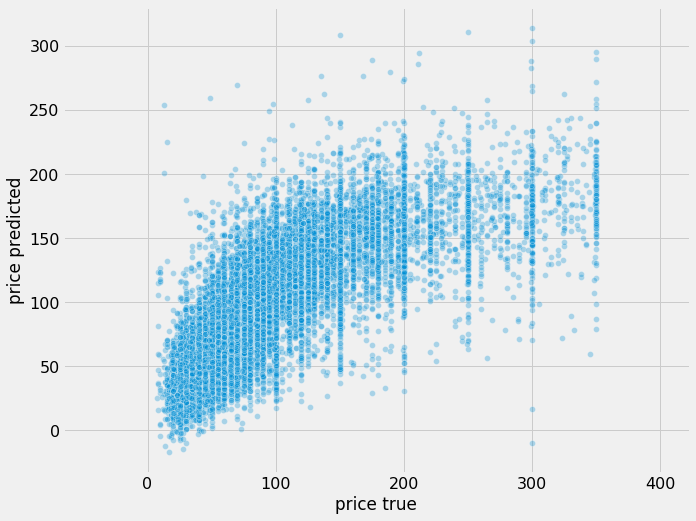

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
ax.set_xlabel('price true')
ax.set_ylabel('price predicted')
plt.axis("equal")
fig.savefig('./img/regression_fig1.png', dpi=150)

*Conclusion*: Despite having a reasonable R2-value, we will need to optimize our model before deploying it. The plot is showing a too strong dispersion and some weaknesses in the upper price levels.

In [102]:
len(df_features.columns)

219

In [103]:
df_ft = pd.DataFrame({'feature':df_features.columns[1:], 'coef':model.coef_})


Let's now take a look which amenities have the strongest positive contribution to the price:

In [104]:
df_plot_data = df_ft[df_ft.feature.str.contains('am_')].nlargest(10, 'coef')
df_plot_data

,feature,coef
45,am_En suite bathroom,20.177034
59,am_Full kitchen,17.838841
4,am_Air conditioning,16.961318
67,am_Heated floors,14.713316
38,am_Dishwasher,14.071723
10,am_Balcony,12.069407
2,am_Accessible-height bed,10.499921
114,am_Smart TV,10.100503
75,am_Indoor fireplace,10.099937
135,am_Wide doorway to guest bathroom,8.969702


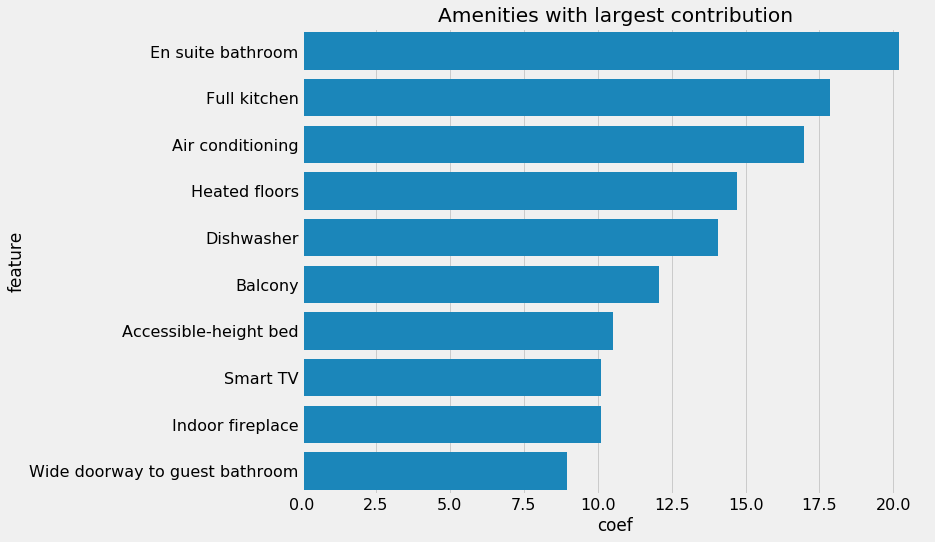

In [106]:
fig, ax = plt.subplots(figsize=(10,8))
df_plot_data['feature'] = df_plot_data['feature'].str.replace('am_','')
ax = sns.barplot(data = df_plot_data, y='feature', x='coef', color='C0' )
ax.set_title('Amenities with largest contribution')
fig.savefig('./img/amenities.png', dpi=150, bbox_inches='tight')

### 3. How to write an attractive description text.

One step to tackle this question might be identifying the keywords used in description texts of successful
listings.  
So, let's try to find the most frequent adjectives and nouns used in reviews by applying the NLTK library.  
As an indicator for a successful listing we will use the rating from reviews.
We will only analyze locations with a top rating of 100 and with more than 10 reviews:

In [161]:
df_top_loc = df_city[(df_city.review_scores_rating == 100.0) & (df_city.number_of_reviews > 10)].copy()
df_top_loc.head(3)

,id,name,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bathrooms,bedrooms,bed_type,amenities,price,accommodates,description,number_of_reviews,review_scores_rating,price_log
75,79488,Charming Apartment Amazing Location,City of Westminster,Westminster,51.51934,-0.16629,Apartment,Entire home/apt,1.5,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",140.0,2,The apartment is Victorian and has well propor...,16,100.0,4.941642
293,276082,Bright Clean Double Room-Chingford,LB of Waltham Forest,Waltham Forest,51.61598,-0.02244,House,Private room,1.0,1.0,Real Bed,"{Wifi,Kitchen,""Free parking on premises"",Break...",50.0,3,I look forward to welcoming you to my beautifu...,17,100.0,3.912023
341,305813,Family room with en suite bathroom,LB of Merton,Merton,51.41715,-0.24570,House,Private room,1.0,1.0,Real Bed,"{TV,Wifi,Pool,Breakfast,""Free street parking"",...",145.0,6,Welcome to Forest Lodge a peaceful luxury fami...,17,100.0,4.976734


In [108]:
# only keep rows with description text:
df_top_loc = df_top_loc[df_top_loc.description.notna()].copy()

At first we create a new column`tokens` with the word tokens of each description text:

In [109]:
#snowball = SnowballStemmer(language = 'english')
df_top_loc.loc[:,'tokens'] = df_top_loc['description'].str.replace(r'[^A-Za-z0-9]', ' ').str.lower().apply(word_tokenize)

Since we are particularly interested in the nouns and adjectives in the text, we will apply NLTK's POS-Tagger:

In [115]:
df_top_loc['tokens'] = df_top_loc.tokens.apply(nltk.pos_tag)

In [117]:
df_top_loc['tokens']

75       [(the, DT), (apartment, NN), (is, VBZ), (victo...
293      [(i, JJ), (look, VBP), (forward, RB), (to, TO)...
341      [(welcome, NN), (to, TO), (forest, VB), (lodge...
417      [(first, RB), (class, NN), (modern, JJ), (mast...
457      [(london, NN), (home, NN), (available, JJ), (f...
                               ...                        
78295    [(double, JJ), (bedroom, NN), (in, IN), (a, DT...
78319    [(incredible, JJ), (central, JJ), (located, VB...
78332    [(this, DT), (very, RB), (bright, JJ), (and, C...
78932    [(very, RB), (large, JJ), (one, CD), (bedroom,...
80504    [(a, DT), (bright, JJ), (and, CC), (airy, JJ),...
Name: tokens, Length: 2045, dtype: object

In [119]:
df_tokens  =df_top_loc['tokens'].explode()
df_tokens

75              (the, DT)
75        (apartment, NN)
75              (is, VBZ)
75        (victorian, JJ)
75              (and, CC)
               ...       
80504           (the, DT)
80504    (thameslink, NN)
80504          (line, NN)
80504          (into, IN)
80504    (blackfriar, NN)
Name: tokens, Length: 321048, dtype: object

In [121]:
df_tokens[~df_tokens.isin(stopwords.words('english'))].value_counts()

(and, CC)          14019
(the, DT)          13785
(a, DT)            10610
(to, TO)            8566
(is, VBZ)           6594
                   ...  
(alounak, NN)          1
(manor, JJ)            1
(recitals, NNS)        1
(watchers, NNS)        1
(aswell, NN)           1
Name: tokens, Length: 14430, dtype: int64

Let's now build two separate data frames for adjectives and nouns:

In [134]:
df_adjectives = df_tokens.apply(lambda x: x if (x[1] in [ 'JJ', 'JJR', 'JJS']) else np.nan)
df_adjectives = df_adjectives[df_adjectives.notna()].apply(lambda x: x[0])
df_adjectives.value_counts().head(20)

double         1314
flat           1308
large          1183
central        1075
private         960
quiet           896
available       860
spacious        767
london          765
great           731
modern          715
comfortable     608
beautiful       569
high            543
open            496
own             495
local           476
new             447
bright          419
free            413
Name: tokens, dtype: int64

In [135]:
df_nouns = df_tokens.apply(lambda x: x if (x[1] in [ 'NN', 'NNS', 'NNP', 'NNPS']) else np.nan)
df_nouns = df_nouns[df_nouns.notna()].apply(lambda x: x[0])
df_nouns.value_counts().head(20)

room           2736
bedroom        1916
london         1715
kitchen        1453
bathroom       1360
minutes        1342
house          1328
apartment      1308
station        1283
area           1195
walk           1129
access         1123
home           1067
garden         1065
street         1010
space           983
bed             955
guests          954
floor           918
restaurants     907
Name: tokens, dtype: int64

Plot the 20 most frequent words:

Text(0.5, 1.0, 'Most frequent nouns in description texts:')

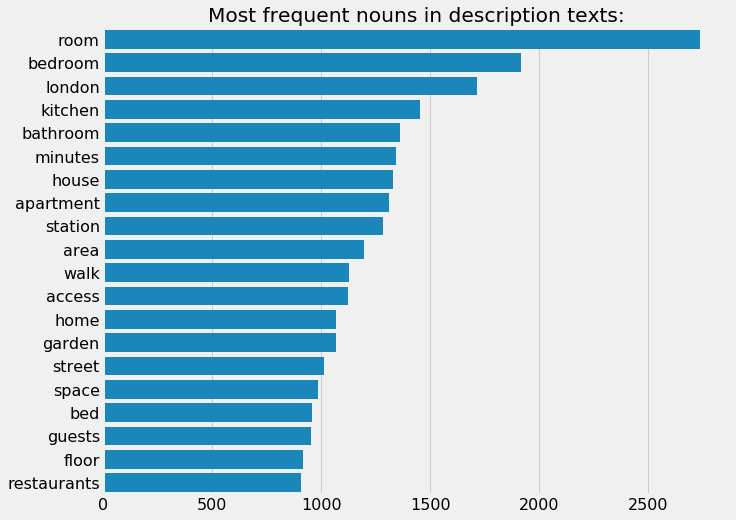

In [162]:
df_plot_data = df_nouns.value_counts().head(20)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=df_plot_data.values, y=df_plot_data.index, color='C0')
ax.set_title('Most frequent nouns in description texts:')

Text(0.5, 1.0, 'Most frequent adjectives in description texts:')

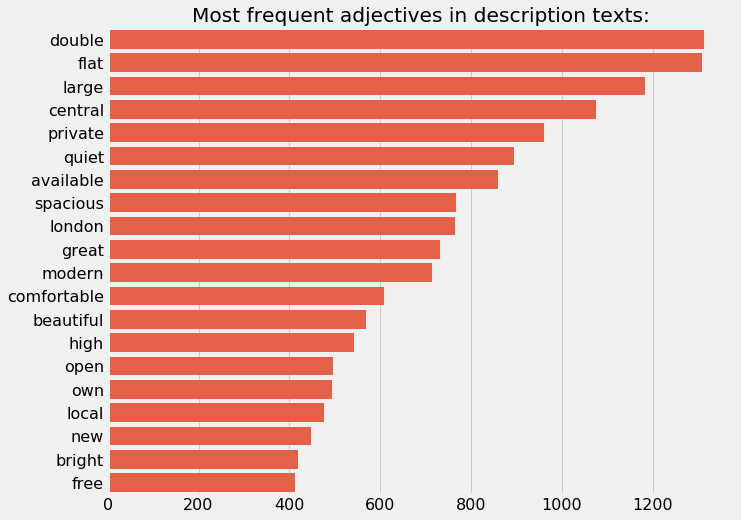

In [165]:
df_plot_data = df_adjectives.value_counts().head(20)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=df_plot_data.values, y=df_plot_data.index, color='C1')
ax.set_title('Most frequent adjectives in description texts:')

Additionally, we will create a wordcloud afer removing the stop words:

In [166]:
adjective_string = " ".join([w for w in df_adjectives.values if w not in stopwords.words('english')])

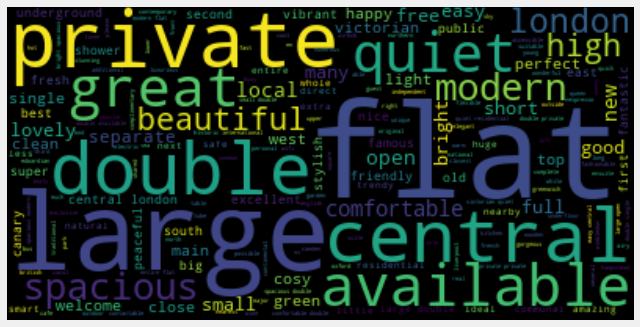

In [167]:
wordcloud = WordCloud().generate(adjective_string)

# Display the generated image:
fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [159]:
noun_string = " ".join([w for w in df_nouns.values if w not in stopwords.words('english')])

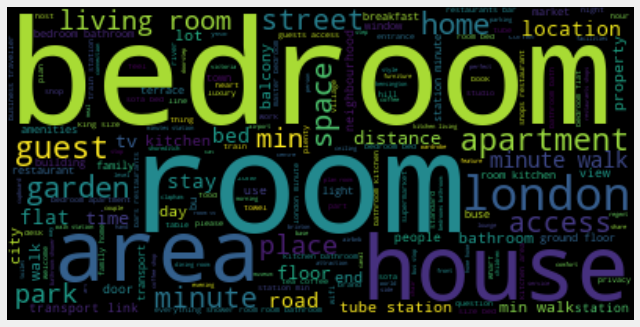

In [160]:
wordcloud = WordCloud().generate(noun_string)

# Display the generated image:
fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()